# Ensemble Model

This uses models that are split between high cost neighborhoods, and low cost neighborhoods. Refine how we want to split up the models.

In [11]:
# Packages
import os 
import re

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# other
from sklearn.decomposition import PCA

# turn off the df['col'] = x assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
# read in data
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

Functions for data cleaning and feature engineering

In [13]:
# na cleaning
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df.loc[:, var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df.loc[:, var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df.loc[:, 'MasVnrType'].fillna('None', inplace = True)
    df.loc[:, 'Electrical'].fillna('SBrkr', inplace = True)
    df.loc[:, 'MSZoning'].fillna('RL', inplace = True)
    df.loc[:, 'SaleType'].fillna('WD', inplace = True)
    df.loc[:, 'Utilities'].fillna('AllPub', inplace = True)
    df.loc[:, 'KitchenQual'].fillna('TA', inplace = True)
    df.loc[:, 'Functional'].fillna('Typ', inplace = True)

    # other cat vars just put "missing" if there isn't an obvious most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df.loc[:, var].fillna("Missing", inplace = True)

    return df






# Function for some standard feature engineering to use in all models
def standard_feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''


    #-----OUTLIERS-----#
    if test_data:
        pass 
    else:
        df = df.loc[(df['LotFrontage'] < 250) & (df['SalePrice'] < 700000) & (df['LotArea'] < 100000)]
    




    #-----SIMPLIFYING VARS-----#

    # num features to just binarize b/c few houses have the feature
    df.loc[:, "SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    
    # combining porch features into 1 later on instead
    #df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    #df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df.loc[:, 'LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df.loc[:, 'MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df.loc[:, 'MSSubClass'] = df['MSSubClass'].astype("object")

    # electrical:
    df.loc[:, 'Electrical'] = df['Electrical'].map(lambda x: "SBrkr" if x == "SBrkr" else "Fuse")
    
    # exterior:
    df.loc[:, 'Exterior'] = df['Exterior1st'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Expensive" if (x in ("VinylSd", "CemntBd", "Stone", "ImStucc")) else(
        "Cheap" if (x in ("BrkComm", "AsphShn", "CBlock", "AsbShng")) else(
        "Moderate")))
    df = df.drop(columns=['Exterior1st', 'Exterior2nd'])
    
    # garage
    df.loc[:, 'GarageQual'] = df['GarageQual'].map(lambda x: 
        # group exterior into simplified var based on average prices
        "Good" if (x in ("Ex", "Gd")) else(
        "Medium" if (x in ("TA")) else(
        "Bad")))
    df.loc[:, 'Heating'] = df['Heating'].map(lambda x: "Gas" if x in ("GasA", "GasW") else "Other")

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df.loc[:, 'Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # add porch square feet together
    df.loc[:, 'PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace=True)

    # simplify the bathrooms variable
    df.loc[:, 'Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)





    #-----DROPPING VARIABLES-----#

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        # not much variation:
        "LowQualFinSF", 
        "LandSlope", 
        "MiscVal", 
        "RoofMatl",
        #"Condition2",
        #"KitchenAbvGr" 
        "PoolArea", # binarized above
        "Utilities", # only 1 obs in training data different from regular
        "HouseStyle" # already explained in other vars
        ]
    df.drop(columns=vars_to_drop, inplace=True) 





    #-----ADDING NEW FEATURES-----#

    # remodeled feature
    df.loc[:, 'Remodeled'] = np.array((df.YearRemodAdd-df.YearBuilt) == 0, dtype=int)

    # expensive neighborhoods
    top_10_neighborhoods = ['NoRidge', 'NridgHt', 'StoneBr','Timber','Veenker','Somerst','ClearCr','Crawfor','CollgCr','Blmngtn']
    df.loc[:, 'ExpensiveNeighborhood'] = df['Neighborhood'].map(lambda x: 1 if x in top_10_neighborhoods else 0)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df.loc[:, 'LogSalePrice'] = np.log(df.SalePrice)

    return df


# more streamlined pre-processing for other functions
def encode_and_standardize(df, test_data=False):
    
    # run normal data clean steps above
    df = standard_feature_eng(na_clean(df), test_data=test_data)

    # if it's train data, we don't want to standardize the response variable
    if not test_data:
        df_y = df[['SalePrice', 'LogSalePrice']]
        df = df.drop(columns=['SalePrice', 'LogSalePrice'])
        
    # build one hot encoder based on the regular training data
    train_one_hot = standard_feature_eng(na_clean(train)).drop(columns=['SalePrice', 'LogSalePrice'])
    enc = OneHotEncoder(handle_unknown = 'ignore').fit(train_one_hot.select_dtypes(include=["object"]))
    one_hot_column_nms = pd.get_dummies(train_one_hot.select_dtypes(include=["object"])).columns

    # one hot encode input df
    categorical_cols = pd.DataFrame(enc.transform(df.select_dtypes(include=["object"])).toarray())
    categorical_cols.columns = one_hot_column_nms
    categorical_cols = categorical_cols.astype("int")
    
    # align the indexes before the merge
    df.index = categorical_cols.index
    df = pd.concat([categorical_cols, df.select_dtypes(exclude=["object"])], axis=1) 
        
    # need col names later
    all_col_names = df.columns
    
    # standardize the data between [0, 1]
    myMinMax = MinMaxScaler()
    df = pd.DataFrame(myMinMax.fit_transform(df))
    df.columns = all_col_names

    # if it's train data, bring back in the response variable
    if not test_data:
        df_y.index = df.index
        df = pd.concat([df, df_y], axis=1) 

    return df 


# works
#encode_and_standardize(test, test_data=True)
#encode_and_standardize(train)

# Lasso

In [14]:
# use same random forest data cleaner
def rf_df_clean_high_low(df, test_data = False):

    # first run standard data cleaning steps
    df = encode_and_standardize(df, test_data=test_data)
    
    # drop neighborhood var
    df = df.drop(columns=list(filter(lambda x: re.search("^Neighborhood_", x), df.columns)))
    
    # DO FEATURE ENGINEERING HERE

    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df


# split data into high and low value neighborhoods
train_high = rf_df_clean_high_low(train)
train_high = train_high.loc[train_high.ExpensiveNeighborhood == 1]

train_low = rf_df_clean_high_low(train)
train_low = train_low.loc[train_low.ExpensiveNeighborhood == 0]

# split up the test data too just like i will in the model
test_high = rf_df_clean_high_low(test, test_data=True)
test_high_y = np.log(sample.loc[test_high.ExpensiveNeighborhood == 1]['SalePrice'])
test_high = test_high.loc[test_high.ExpensiveNeighborhood == 1]

test_low = rf_df_clean_high_low(test, test_data=True)
test_low_y = np.log(sample.loc[test_low.ExpensiveNeighborhood == 0]['SalePrice'])
test_low = test_low.loc[test_low.ExpensiveNeighborhood == 0]

# choosing to manually introduce a larger penalty
final_alpha = .01

# fit model high
lasso_high = Lasso(alpha=final_alpha)\
    .fit(train_high.drop(columns=['SalePrice', 'LogSalePrice']), train_high.LogSalePrice)

# fit model low
lasso_low = Lasso(alpha=final_alpha)\
    .fit(train_low.drop(columns=['SalePrice', 'LogSalePrice']), train_low.LogSalePrice)


# build the lasso combination function
def lasso_high_low(df, test_data=False):

    df = rf_df_clean_high_low(df, test_data=test_data)
    
    # create id to put df back into same exact order
    df['Id'] = list(range(0, df.shape[0]))

    # split dataset into high low
    df_high = df.loc[df.ExpensiveNeighborhood == 1]
    df_low = df.loc[df.ExpensiveNeighborhood == 0]

    # run lasso on high/low
    if test_data:

        df_high = df_high.assign(yhat = lasso_high.predict(df_high.drop(columns=["Id"])))
        df_low = df_low.assign(yhat = lasso_low.predict(df_low.drop(columns=["Id"])))
        
    else:

        df_high = df_high.assign(yhat = lasso_high.predict(df_high.drop(columns=["Id", 'SalePrice', 'LogSalePrice'])))
        df_low = df_low.assign(yhat = lasso_low.predict(df_low.drop(columns=["Id", 'SalePrice', 'LogSalePrice'])))

    # combine, sort values, and return results
    df_preds = pd.concat([df_high[['Id', 'yhat']], df_low[['Id', 'yhat']]], axis=0)
    df_preds = df_preds.sort_values("Id", ascending=True)
    
    return np.array(df_preds.yhat)


# Evaluate performance
yhat_train = lasso_high_low(train)
yhat_test = lasso_high_low(test, test_data=True)

# rmse
rmse_train = (np.mean((yhat_train - np.log(rf_df_clean_high_low(train).SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Log RMSE on training data: 0.177
Log RMSE on testing data: 0.331


# Random Forest

In [15]:
# Random forest data clean function
def rf_df_clean_high_low(df, test_data = False):

    # first run standard data cleaning steps
    df = encode_and_standardize(df, test_data=test_data)
    
    # drop neighborhood var
    df = df.drop(columns=list(filter(lambda x: re.search("^Neighborhood_", x), df.columns)))
    
    # DO FEATURE ENGINEERING HERE

    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df

# split data into high and low value neighborhoods
train_high = rf_df_clean_high_low(train)
train_high = train_high.loc[train_high.ExpensiveNeighborhood == 1]

train_low = rf_df_clean_high_low(train)
train_low = train_low.loc[train_low.ExpensiveNeighborhood == 0]

# split up the test data too just like i will in the model
test_high = rf_df_clean_high_low(test, test_data=True)
test_high_y = np.log(sample.loc[test_high.ExpensiveNeighborhood == 1]['SalePrice'])
test_high = test_high.loc[test_high.ExpensiveNeighborhood == 1]

test_low = rf_df_clean_high_low(test, test_data=True)
test_low_y = np.log(sample.loc[test_low.ExpensiveNeighborhood == 0]['SalePrice'])
test_low = test_low.loc[test_low.ExpensiveNeighborhood == 0]

# high cost RF
rf_reg_high = RandomForestRegressor(
    n_estimators = 400,
    max_depth = 15, #17
    max_features = .33, # .33
    min_samples_split = 2,
    ccp_alpha = 1e-3, #0.001
    #bootstrap = True, 
    random_state=1
    )

# fit the model
rf_reg_high.fit(train_high.drop(columns = ["SalePrice", 'LogSalePrice']), train_high.LogSalePrice)


# low cost rf
rf_reg_low = RandomForestRegressor(
    n_estimators = 450, # 500
    max_depth = 14, # 22
    max_features = .33, # 'auto',
    min_samples_split=3, 
    ccp_alpha=1e-6, 
    bootstrap = True, 
    random_state=1
    ) # 0.3533

# fit the model
rf_reg_low.fit(train_low.drop(columns = ["SalePrice", 'LogSalePrice']), train_low.LogSalePrice)

# function to combine high and low
def rf_high_low(df, test_data=False):

    df = rf_df_clean_high_low(df, test_data=test_data)
    
    # create id to put df back into same exact order
    df['Id'] = list(range(0, df.shape[0]))

    # split dataset into high low
    df_high = df.loc[df.ExpensiveNeighborhood == 1]
    df_low = df.loc[df.ExpensiveNeighborhood == 0]

    # run rf on high/low
    if test_data:
        df_high = df_high.assign(yhat = rf_reg_high.predict(df_high.drop(columns="Id")))
        df_low = df_low.assign(yhat = rf_reg_low.predict(df_low.drop(columns="Id")))
    else:
        df_high = df_high.assign(yhat = rf_reg_high.predict(df_high.drop(columns=["Id", "SalePrice", "LogSalePrice"])))
        df_low = df_low.assign(yhat = rf_reg_low.predict(df_low.drop(columns=["Id", "SalePrice", "LogSalePrice"])))

    # combine, sort values, and return results
    df_preds = pd.concat([df_high[['Id', 'yhat']], df_low[['Id', 'yhat']]], axis=0)
    df_preds = df_preds.sort_values("Id", ascending=True)
    return np.array(df_preds.yhat)    

In [16]:
# Evaluate performance
yhat_train = rf_high_low(train)
yhat_test = rf_high_low(test, test_data=True)

# rmse
rmse_train = (np.mean((yhat_train - np.log(rf_df_clean_high_low(train).SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Log RMSE on training data: 0.080
Log RMSE on testing data: 0.367


# XGBoost

In [17]:
# Random forest data clean function
def rf_df_clean_high_low(df, test_data = False):

    # first run standard data cleaning steps
    df = encode_and_standardize(df, test_data=test_data)
    
    # drop neighborhood var
    df = df.drop(columns=list(filter(lambda x: re.search("^Neighborhood_", x), df.columns)))
    
    # DO FEATURE ENGINEERING HERE

    # drop irrelevant columns
    df = df.drop(columns=["Id"])
    
    return df


# split data into high and low value neighborhoods
train_high = rf_df_clean_high_low(train)
train_high = train_high.loc[train_high.ExpensiveNeighborhood == 1]

train_low = rf_df_clean_high_low(train)
train_low = train_low.loc[train_low.ExpensiveNeighborhood == 0]

# split up the test data too just like i will in the model
test_high = rf_df_clean_high_low(test, test_data=True)
test_high_y = np.log(sample.loc[test_high.ExpensiveNeighborhood == 1]['SalePrice'])
test_high = test_high.loc[test_high.ExpensiveNeighborhood == 1]

test_low = rf_df_clean_high_low(test, test_data=True)
test_low_y = np.log(sample.loc[test_low.ExpensiveNeighborhood == 0]['SalePrice'])
test_low = test_low.loc[test_low.ExpensiveNeighborhood == 0]

# high cost xgb
xgb_high = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    n_estimators=400,
    max_depth=10,
    learning_rate=.05, 
    
    reg_alpha=0, 
    reg_lambda=.1, 

    subsample=.5, 
    colsample_bytree=.7, 
    random_state=1
)

# fit to train
xgb_high.fit(train_high.drop(columns=["SalePrice", "LogSalePrice"]), train_high['LogSalePrice'])

# low cost xgb
xgb_low = xgb.XGBRegressor(
    booster="gbtree",
    verbosity=0,
    n_estimators=500,
    max_depth=7,
    learning_rate=.05, 
    
    reg_alpha=0, 
    reg_lambda=.09, 

    subsample=.5, 
    colsample_bytree=.7, 
    random_state=1
)

# fit to train
xgb_low.fit(train_low.drop(columns=["SalePrice", "LogSalePrice"]), train_low['LogSalePrice'])

# function to combine high and low
def xgb_high_low(df, test_data=False):

    df = rf_df_clean_high_low(df, test_data=test_data)

    # create id to put df back into same exact order
    df['Id'] = list(range(0, df.shape[0]))

    # split dataset into high low
    df_high = df.loc[df.ExpensiveNeighborhood == 1]
    df_low = df.loc[df.ExpensiveNeighborhood == 0]

    # run rf on high/low
    if test_data:
        df_high = df_high.assign(yhat = xgb_high.predict(df_high.drop(columns="Id")))
        df_low = df_low.assign(yhat = xgb_low.predict(df_low.drop(columns="Id")))
    else:
        df_high = df_high.assign(yhat = xgb_high.predict(df_high.drop(columns=["Id", "SalePrice", "LogSalePrice"])))
        df_low = df_low.assign(yhat = xgb_low.predict(df_low.drop(columns=["Id", "SalePrice", "LogSalePrice"])))

    # combine, sort values, and return results
    df_preds = pd.concat([df_high[['Id', 'yhat']], df_low[['Id', 'yhat']]], axis=0)
    df_preds = df_preds.sort_values("Id", ascending=True)
    
    return np.array(df_preds.yhat)


# Evaluate performance
yhat_train = xgb_high_low(train)
yhat_test = xgb_high_low(test, test_data=True)

# rmse
rmse_train = (np.mean((yhat_train - np.log(rf_df_clean_high_low(train).SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Log RMSE on training data: 0.003
Log RMSE on testing data: 0.404


# Ensemble

In [18]:
# Load in brand new data to make sure it all works
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

In [19]:
# the final ensemble model
def housing_ensemble_model(df, test_data=True, output_type="preds"):
    '''This is the final model that takes in raw data, and makes predictions'''


    # Lasso
    yhat_lasso = lasso_high_low(df, test_data=test_data)

    # Random forest
    yhat_rf = rf_high_low(df, test_data=test_data)

    # XGB
    yhat_xgb = xgb_high_low(df, test_data=test_data)

    # make ensemble prediction
    # Do more work to come up w/ weights. This is just a sample
    yhat_final = (yhat_lasso + yhat_rf + yhat_xgb) / 3

    if output_type == "preds":

        return yhat_final

    elif output_type == "df":
        result_df = pd.DataFrame({
            "lasso": yhat_lasso, 
            "rf": yhat_rf, 
            "xgb": yhat_xgb, 
            "ensemble": yhat_final
        })

        return result_df

    elif output_type == "test performances":
        result_df = {
            "lasso": np.mean((np.log(sample.SalePrice) - yhat_lasso)**2)**.5,
            "rf": np.mean((np.log(sample.SalePrice) - yhat_rf)**2)**.5,
            "xgb": np.mean((np.log(sample.SalePrice) - yhat_xgb)**2)**.5,
            "ensemble": np.mean((np.log(sample.SalePrice) - yhat_final)**2)**.5, 
        }

        return result_df

    else:
        return yhat_final


# Evaluate performance
yhat_train = housing_ensemble_model(train, test_data=False)
yhat_test = housing_ensemble_model(test, test_data=True)

# rmse
rmse_train = (np.mean((yhat_train - np.log(rf_df_clean_high_low(train).SalePrice))**2))**.5
rmse_test = (np.mean((yhat_test - np.log(sample.SalePrice))**2))**.5

print("Log RMSE on training data: {:.3f}".format(rmse_train))
print("Log RMSE on testing data: {:.3f}".format(rmse_test))

Log RMSE on training data: 0.081
Log RMSE on testing data: 0.361


# Extra nice model outputs

In [20]:
# export results
pd.DataFrame({
    "Id": sample.Id, 
    "SalePrice": np.exp(housing_ensemble_model(test))
}).to_csv("~/Desktop/ensemble_high_low.csv", index=False)


In [158]:
# see accuracies
housing_ensemble_model(test, test_data=True, output_type="test performances")

{'lasso': 0.3310738468434718,
 'rf': 0.36705039356308256,
 'xgb': 0.40378204435289544,
 'ensemble': 0.36051494807552203}

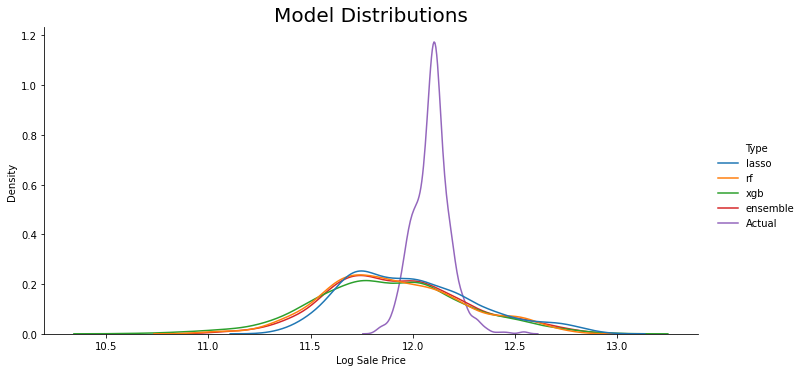

In [156]:
# see distribution of the accuracies
result_df = housing_ensemble_model(test, output_type="df")
result_df = pd.concat([result_df, 
    pd.DataFrame({"Actual": np.log(sample.SalePrice)})
    ], axis=1)

result_df = result_df.melt(var_name="Type", value_name="log_sale_price")
result_df

sns.reset_orig()
sns.displot(result_df, x="log_sale_price", hue="Type", kind="kde", aspect=2).set_axis_labels(x_var="Log Sale Price")
plt.title("Model Distributions",fontdict={"fontsize": 20})
print("")

# Kaggle Submission

Score: 0.17665